In [6]:
import numpy as np
from itertools import product
from scipy.optimize import fsolve


class betrand_model(object):

    def __init__(self, **kwargs):
        """Initialize game with default values"""
        # Default properties
        self.numPlayers = 2
        self.alpha = kwargs.get('alpha', 0.15)
        self.beta = kwargs.get('beta', 4e-6)
        self.delta = kwargs.get('delta', 0.95)
        
        self.c = kwargs.get('c', 1)
        self.a = kwargs.get('a', 2)
        self.a0 = kwargs.get('a0', 0)
        self.mu = kwargs.get('mu', 0.25)
        self.penalty = kwargs.get('penalty',-2)
        self.reward = kwargs.get('reward',5)
        self.k = kwargs.get('k',15)
        self.numiActions = self.k ** 2
        self.numActions = self.numiActions ** self.numPlayers

        self.eps = kwargs.get('eps',0.5)

        # Derived properties
        self.indexActions = self.init_indexActions()
        self.sdim, self.s0 = self.init_state()
        self.p_minmax_cost_1 = self.compute_p_competitive_monopoly(c = 1)
        self.init_actions()
        
        self.Profits,self.Penalty = self.init_Profits()
        self.Q = self.init_Q()

        self.cActions = self.init_cActions()

        
    def demand(self, p):
        e = np.exp((self.a - p) / self.mu)
        d = e / (np.sum(e) + np.exp(self.a0 / self.mu))
        return d

    
    def foc(self, p, c):
        d = self.demand(p)
        zero = 1 - (p - c) * (1 - d) / self.mu
        return np.squeeze(zero)

    
    def foc_monopoly(self, p, c):
        d = self.demand(p)
        d1 = np.flip(d)
        p1 = np.flip(p)
        zero = 1 - (p - c) * (1 - d) / self.mu + (p1 - c) * d1 / self.mu
        return np.squeeze(zero)
    
    
    def foc1_monopoly(self,p,c):
        zero = -p + c + self.mu*(1+np.exp((self.a-p-self.a0)/self.mu))
        return zero
    
    def compute_p_monopoly_1(self,c):
        p0 = c
        p_monopoly = fsolve(self.foc1_monopoly,p0,args = (c,))
        return p_monopoly

    
    def compute_p_competitive_monopoly(self, c):
        p0 = np.ones((1, self.numPlayers)) * 1 * c
        p_competitive = fsolve(self.foc, p0,args = (c,))
        p_monopoly = fsolve(self.foc_monopoly, p0,args = (c,))
        return p_competitive, p_monopoly

    
    
    def init_actions(self):
        a = np.linspace(min(self.p_minmax_cost_1[0]), max(self.p_minmax_cost_1[1]), self.k - 2)
        delta = a[1] - a[0]
        A = np.linspace(min(a) - delta, max(a) + delta, self.k)
        self.player_actions = A
        self.player_cost = self.player_actions - self.mu*(1+1/(self.numPlayers-1 + \
                                      np.exp((self.a0-self.a+self.player_actions)/self.mu)))
        self.player_cost[np.abs(self.player_cost-self.c)<1e-5] = self.c
        self.buyer_action_list = np.array(list(product(A, repeat=2)))
        self.buyer_cost_list = np.array(list(product(self.player_cost, repeat=2)))
        self.seller_action_list = np.array(list(product(A, repeat=2)))
        self.seller_cost_list = np.array(list(product(self.player_cost, repeat=2)))
    
    
    def init_indexActions(self):
        
        indexActions = []
        for i in range(self.numActions):
            
            indexActions.append(self.convertNumberBase(i, self.numiActions, self.numPlayers))
            
        indexActions = np.array(indexActions)
        
        return indexActions

    
    def init_state(self):
        sdim = (self.k, self.k)
        s0 = np.zeros(len(sdim)).astype(int)
        return sdim, s0
    
    
    def init_cActions(self):
        """Initialize cActions (used for q-learning)"""
        
        x = np.arange(self.numPlayers - 1, -1, -1)
        cActions = self.numiActions ** x
        
        return cActions

    
    def compute_profits(self, p, c):
        d = self.demand(p)
        pi = (p - c) * d
        return pi

    
    def init_Profits(self):
        Profits = np.zeros((2,self.numActions, self.numPlayers))
        Penalty = np.zeros((2,self.numActions, self.numPlayers))        
        Actions = np.zeros((self.numActions, 4))
        
        for i in range(self.numActions):
            b = int(self.indexActions[i][0])
            s = int(self.indexActions[i][1])
            
            cb,cb_a = self.buyer_cost_list[b]
            cs,cs_a = self.seller_cost_list[s]
            vb,vb_a = self.buyer_action_list[b]
            vs,vs_a = self.seller_action_list[s]
            penalb = 0
            penals = 0
            penals_na = 0
            penalb_na = 0
            
            Actions[i] = cb, cb_a,cs,cs_a
            
        #No mechanism

            p = np.array([vb,vs])

            c = np.array([1,1])
            pb_na,ps_na = self.compute_profits(p,c)
            if cb == cs: 
                pb = pb_na
                ps = ps_na


            else:
                price_b = self.compute_p_monopoly_1(c = cb_a)[0]
                p = np.array([price_b,100000])
                c = np.array([1,1])   
                pb,ps_ = 0.5*0 + 0.5*self.compute_profits(p,c)

                
                price_s = self.compute_p_monopoly_1(c = cs_a)[0]
                p = np.array([100000,price_s])
                c = np.array([1,1])                
                pb_,ps = 0.5*0 + 0.5*self.compute_profits(p,c)                
                
                penalb = 0.5*self.penalty
                penals = 0.5*self.penalty
                pb = pb + 0.5*self.penalty
                ps = ps + 0.5*self.penalty
                
                #ps = self.penalty
                if cb == cs_a:
                    penalb = 0.5*self.reward
                    pb += 0.5*self.reward
                    
                else:
                    penalb += 0.5*self.penalty
                    pb += 0.5*self.penalty
                    
                if cs == cb_a:
                    penals = 0.5*self.reward
                    ps += 0.5*self.reward
                    
                else:
                    penals += 0.5*self.penalty
                    ps += 0.5*self.penalty

#             print('cb:',format(cb,'.2f'),'     cb_a:',format(cb_a,'.2f'),'     cs:',format(cs,'.2f'),\
#             '     cs_a:',format(cs_a,'.2f'),'     pb:',format(pb,'.2f'),'     ps:',format(ps,'.2f'))
  
            Profits[1][i] = [pb, ps]
            Profits[0][i] = [pb_na,ps_na]
            Penalty[1][i] = [penalb,penals]
            Penalty[0][i] = [penalb_na,penals_na]            

        return Profits,Penalty
            
            

    
    def init_Q(self):
        Q = np.zeros((self.numiActions, self.numPlayers))

        return Q
    
        
    
    
    @staticmethod
    def convertNumberBase(n, b, l):
        '''
        Converts an integer n from base 10 to base b,
        generating a vector of integers of length l
        '''
        tmp = n
        ans = np.zeros(l)
        for i in range(1, l+1):
            ans[l-i] = int(tmp % b)
            tmp = np.floor(tmp/b)
        return ans



In [19]:
import numpy as np

# from SRModel import SRModel

    
class betrand_Qlearning(object):
    '''
        Qlearning based on SR model
    '''
    def __init__(self, **kwargs):

        self.delta = kwargs.get('delta', 0.95)
        
        self.reward = kwargs.get('reward',50)
        self.penalty = kwargs.get('penalty',-50)

        self.convergedtime = kwargs.get('convergedtime',500)
        self.numSessions = kwargs.get('numSessions',1)
        self.maxIters = kwargs.get('maxIters',100000)

        self.c = kwargs.get('c',1)
        self.eps = kwargs.get('eps',0.5)
        self.theta = kwargs.get('theta',0.0001)
        
        self.game = betrand_model(delta = self.delta,\
                                   reward = self.reward,penalty = self.penalty,c = self.c,eps = self.eps)
        self.alpha = kwargs.get('alpha', 0.25) * np.ones(self.game.numPlayers)
        self.beta = kwargs.get('beta', 0.0005) * np.ones(self.game.numPlayers)
        self.initial_state = kwargs.get('initial_state',0)

        self.state_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)        
        
        self.delta = kwargs.get('delta',0.95)
        
               
    def computePPrime(self, strategyPrime, iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            if np.random.uniform(0,1) < np.exp(-self.beta[iPlayer]*iters):

                pPrime[iPlayer] = np.floor(self.game.numiActions*np.random.uniform(0,1))
            else:
                pPrime[iPlayer] = strategyPrime[iPlayer]
                
        return pPrime
    
    
    def computePPrime2(self):
        
        pPrime = np.zeros(self.game.numPlayers)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            random_numbers = np.random.uniform(0,1)
            
            q_list = self.Q[:,iPlayer]
            
            p_list = np.exp(5*q_list)/np.exp(5*q_list).sum()
            
            p_list = p_list.cumsum()
            for i in range(self.game.numiActions-1):
                if p_list[i]<=random_numbers:
                    if p_list[i+1]> random_numbers:
                        pPrime[iPlayer] = i
            
        return pPrime
    
    
    def computePPrime2_t(self,iters):
        
        pPrime = np.zeros(self.game.numPlayers)
        T = 1/((iters+1)*self.theta)
        #  Greedy with probability 1-epsilon, with exponentially decreasing epsilon
        
        for iPlayer in range(self.game.numPlayers):
            
            random_numbers = np.random.uniform(0,1)
            
            q_list = self.Q[:,iPlayer]
            
            p_list = np.exp(q_list/T)/np.exp(q_list/T).sum()
            
            p_list = p_list.cumsum()
            for i in range(self.game.numiActions-1):
                if p_list[i]<=random_numbers:
                    if p_list[i+1]> random_numbers:
                        pPrime[iPlayer] = i
            
        return pPrime
    


    def q_learning(self):

        # Initializing various quantities

        indexStrategies = np.zeros((self.game.numPlayers,self.numSessions))

        indexConverge = np.zeros((self.game.numPlayers,self.numSessions))
        
        self.profit_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)
        self.penalty_list = np.full((self.numSessions,self.maxIters,self.game.numPlayers),np.nan)

        # Loop over numSessions
        for iSession in range(self.numSessions):
            
            
            # Learning Phase
            
            # Initialization
            self.Q = self.game.Q.copy()
            strategyPrime = np.zeros(self.game.numPlayers)

            
            # Loop
            itersInStrategy = 0
            convergedSession = -1
            
            strategyFix = np.zeros(self.game.numPlayers)
            
            for iters in range(self.maxIters):
                old_strategy = strategyPrime.copy()                
                # Iterations counter
                   
                #pPrime = self.computePPrime(strategyPrime,iters)
                pPrime = self.computePPrime2_t(iters)
                state = int(np.sum(self.game.cActions*pPrime)) 
                
                for iPlayer in range(self.game.numPlayers):
                    
                    # Q matrices and strategies update
                    if np.random.uniform(0, 1) < 1 - self.game.eps:
                        profits = self.game.Profits[0][state, iPlayer]
                    else:
                        profits = self.game.Profits[1][state, iPlayer]
                        
                    oldq = self.Q[int(pPrime[iPlayer]), iPlayer]
                    newq = oldq + self.alpha[iPlayer] * (profits - oldq)
                    #print('pppppp',state1)
                    self.Q[int(pPrime[iPlayer]), iPlayer] = newq
                    
                strategyPrime = pPrime
                self.state_list[iSession,iters,:] = pPrime
                #print(strategyPrime,pPrime)
                # Assessing convergence
                if iters>self.maxIters-100:
                    print([int(strategyPrime[0]//15),int(strategyPrime[0]%15),\
                           int(strategyPrime[1]//15),int(strategyPrime[1]%15)])
                
                vb, vb_a = self.game.buyer_action_list[int(strategyPrime[0])]
                vs, vs_a = self.game.seller_action_list[int(strategyPrime[1])]
                
                vb_1, vb_a_1 = self.game.buyer_action_list[int(old_strategy[0])]
                vs_1, vs_a_1 = self.game.seller_action_list[int(old_strategy[1])]  
                if vb == vb_1 and vs == vs_1:
                    itersInStrategy = itersInStrategy + 1
                else:
                    itersInStrategy = 1

                # Check for convergence in strategy
                if convergedSession == -1:
                    # Maximum number of iterations exceeded
                    if iters >= self.maxIters - 1:
                        convergedSession = 0


                    if itersInStrategy == self.convergedtime:
                        convergedSession = 1

                    strategyFix = strategyPrime.copy()               #testing

                # Check for loop exit criteria
                if convergedSession != -1:
                    break
                # if no converge yet, update and iterate
    
            indexConverge[:,iSession] = (convergedSession, iters)
            indexStrategies[:,iSession] = strategyFix
            self.indexConverge = indexConverge
            self.indexStrategies = indexStrategies
            #print(iSession,convergedSession)

        return indexConverge, indexStrategies



    

In [24]:
K = betrand_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0001,theta = 0.0001,
                 penalty = -2,reward = 2,c = 1,eps = 1,
                 convergedtime = 500,maxIters = 1000000)
R = K.q_learning()



print(R)


[14, 10, 14, 2]
[14, 12, 14, 9]
[13, 14, 14, 1]
[14, 12, 14, 5]
[14, 2, 13, 14]
[14, 9, 14, 9]
[13, 14, 14, 2]
[14, 6, 14, 3]
[14, 5, 14, 2]
[14, 8, 14, 10]
[13, 14, 14, 3]
[14, 2, 14, 7]
[14, 0, 14, 7]
[13, 14, 14, 5]
[14, 6, 14, 7]
[14, 6, 14, 7]
[14, 0, 14, 2]
[14, 10, 14, 10]
[14, 3, 14, 8]
[14, 3, 14, 7]
[14, 10, 14, 3]
[14, 10, 14, 0]
[14, 5, 14, 8]
[14, 6, 14, 6]
[14, 5, 14, 1]
[14, 0, 14, 10]
[14, 10, 14, 1]
[14, 10, 14, 11]
[14, 12, 14, 3]
[14, 8, 14, 10]
[14, 5, 14, 0]
[14, 10, 14, 10]
[14, 12, 14, 7]
[14, 12, 14, 0]
[14, 12, 14, 3]
[14, 5, 14, 8]
[14, 9, 14, 8]
[14, 10, 14, 6]
[14, 1, 14, 8]
[14, 2, 14, 3]
[14, 0, 14, 5]
[14, 10, 14, 5]
[14, 10, 13, 14]
[14, 0, 14, 9]
[14, 6, 14, 5]
[14, 12, 14, 7]
[14, 11, 13, 14]
[14, 2, 14, 4]
[14, 0, 13, 14]
[13, 14, 14, 7]
[14, 12, 14, 3]
[14, 3, 14, 10]
[14, 1, 14, 5]
[14, 4, 14, 2]
[14, 12, 14, 3]
[14, 4, 14, 7]
[14, 6, 14, 11]
[14, 5, 14, 5]
[14, 3, 14, 10]
[14, 6, 14, 2]
[14, 12, 14, 10]
[14, 8, 14, 8]
[14, 6, 14, 1]
[14, 11, 14, 0]

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


Text(0.5, 1.0, 'price choice for 2 players true price = 1.473 with eps = 1.00')

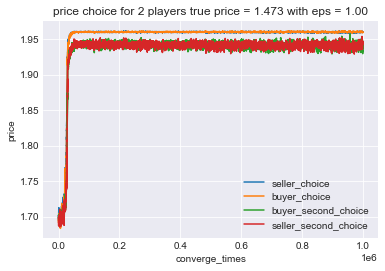

In [25]:
from matplotlib import pyplot as plt
ll = K.state_list.copy()

indexes1 = np.where(~np.isnan(K.state_list[0,:,0]))[0][-1] + 1
lll = np.full((K.numSessions,indexes1,K.game.numPlayers*2),np.nan) 
for i in range(indexes1):
    lll[0,i,0] = ll[0,i,0]//15
    lll[0,i,2] = ll[0,i,1]//15
    if lll[0,i,0] != lll[0,i,2]:
        lll[0,i,1] = ll[0,i,0]%15

        lll[0,i,3] = ll[0,i,1]%15
    else:
        lll[0,i,1] = lll[0,i,0]
        lll[0,i,3] = lll[0,i,2]
for i in range(15):
    lll[lll==i]=K.game.buyer_action_list[::15,0][i]
    
agree_ab_truth_list1 = np.full((indexes1),np.nan)
disagree_ab_truth_list1 = np.full((indexes1),np.nan)
agree_ab_lies_list1 = np.full((indexes1),np.nan)
disagree_ab_lies_list1 = np.full((indexes1),np.nan)
for i in range(indexes1):
    if i%100000 ==0:
        print(i)
    if i>=1000:
        buyer_list = lll[0,i-1000:i,0]
        buyer_brother_list = lll[0,i-1000:i,1]
        seller_list = lll[0,i-1000:i,2]
        seller_brother_list = lll[0,i-1000:i,3]

                              
        agree_ab_truth_list1[i-1000] = np.nanmean(buyer_list)
        disagree_ab_truth_list1[i-1000] = np.nanmean(buyer_brother_list)
        agree_ab_lies_list1[i-1000] = np.nanmean(seller_list)
        disagree_ab_lies_list1[i-1000] = np.nanmean(seller_brother_list)
        
plt.style.use('seaborn-darkgrid')
plt.plot(agree_ab_lies_list1)
plt.plot(agree_ab_truth_list1)
plt.plot(disagree_ab_lies_list1)
plt.plot(disagree_ab_truth_list1)
plt.legend(labels=['seller_choice','buyer_choice',\
                  'buyer_second_choice','seller_second_choice'],loc='best')
plt.xlabel('converge_times')
plt.ylabel('price')
plt.title('price choice for 2 players true price = %.3f with eps = %.2f'\
          %(K.game.buyer_action_list[::15,0][int(K.c)],1))

In [27]:
K = betrand_Qlearning(numSessions = 1,delta = 0.95,alpha = 0.25,beta = 0.0001,theta = 0.0001,
                 penalty = -2,reward = 2,c = 14,eps = 1,
                 convergedtime = 500,maxIters = 1000000)
R = K.q_learning()



print(R)



[14, 6, 14, 7]
[14, 1, 14, 0]
[14, 5, 14, 6]
[13, 14, 14, 9]
[14, 10, 14, 7]
[14, 2, 13, 14]
[13, 14, 14, 9]
[14, 4, 14, 6]
[14, 8, 14, 6]
[14, 4, 13, 14]
[14, 6, 14, 3]
[14, 8, 14, 6]
[14, 11, 14, 12]
[14, 9, 14, 9]
[14, 2, 14, 12]
[14, 11, 14, 10]
[14, 5, 14, 6]
[14, 6, 14, 4]
[14, 11, 14, 12]
[14, 6, 14, 0]
[14, 6, 14, 5]
[14, 2, 14, 0]
[13, 14, 14, 5]
[14, 10, 14, 12]
[14, 1, 14, 3]
[14, 0, 14, 0]
[14, 11, 14, 2]
[14, 9, 14, 9]
[14, 10, 14, 12]
[14, 6, 14, 3]
[14, 4, 14, 5]
[14, 5, 14, 5]
[13, 14, 14, 3]
[14, 8, 14, 6]
[14, 11, 14, 9]
[14, 9, 14, 1]
[14, 2, 14, 7]
[14, 0, 14, 11]
[14, 9, 14, 1]
[14, 0, 14, 6]
[13, 14, 14, 7]
[13, 14, 14, 5]
[14, 4, 14, 7]
[14, 3, 14, 7]
[14, 12, 14, 6]
[13, 14, 13, 14]
[13, 14, 14, 10]
[14, 2, 14, 10]
[14, 5, 14, 10]
[14, 11, 13, 14]
[14, 8, 14, 0]
[14, 12, 14, 6]
[14, 2, 14, 12]
[14, 7, 14, 3]
[14, 2, 14, 0]
[14, 6, 14, 5]
[13, 14, 14, 3]
[14, 6, 13, 14]
[14, 0, 14, 12]
[14, 11, 13, 14]
[14, 2, 14, 8]
[14, 4, 14, 4]
[14, 9, 14, 5]
[14, 11, 14, 7]


0
100000
200000
300000
400000
500000
600000
700000
800000
900000


Text(0.5, 1.0, 'price choice for 2 players true price = 1.963 with eps = 1.00')

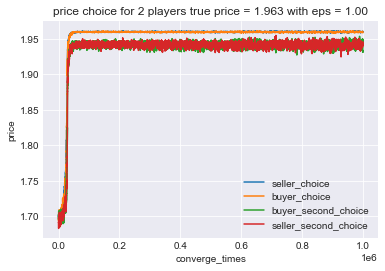

In [28]:
from matplotlib import pyplot as plt
ll = K.state_list.copy()

indexes1 = np.where(~np.isnan(K.state_list[0,:,0]))[0][-1] + 1
lll = np.full((K.numSessions,indexes1,K.game.numPlayers*2),np.nan) 
for i in range(indexes1):
    lll[0,i,0] = ll[0,i,0]//15
    lll[0,i,2] = ll[0,i,1]//15
    if lll[0,i,0] != lll[0,i,2]:
        lll[0,i,1] = ll[0,i,0]%15

        lll[0,i,3] = ll[0,i,1]%15
    else:
        lll[0,i,1] = lll[0,i,0]
        lll[0,i,3] = lll[0,i,2]
for i in range(15):
    lll[lll==i]=K.game.buyer_action_list[::15,0][i]
    
agree_ab_truth_list1 = np.full((indexes1),np.nan)
disagree_ab_truth_list1 = np.full((indexes1),np.nan)
agree_ab_lies_list1 = np.full((indexes1),np.nan)
disagree_ab_lies_list1 = np.full((indexes1),np.nan)
for i in range(indexes1):
    if i%100000 ==0:
        print(i)
    if i>=1000:
        buyer_list = lll[0,i-1000:i,0]
        buyer_brother_list = lll[0,i-1000:i,1]
        seller_list = lll[0,i-1000:i,2]
        seller_brother_list = lll[0,i-1000:i,3]

                              
        agree_ab_truth_list1[i-1000] = np.nanmean(buyer_list)
        disagree_ab_truth_list1[i-1000] = np.nanmean(buyer_brother_list)
        agree_ab_lies_list1[i-1000] = np.nanmean(seller_list)
        disagree_ab_lies_list1[i-1000] = np.nanmean(seller_brother_list)
        
plt.style.use('seaborn-darkgrid')
plt.plot(agree_ab_lies_list1)
plt.plot(agree_ab_truth_list1)
plt.plot(disagree_ab_lies_list1)
plt.plot(disagree_ab_truth_list1)
plt.legend(labels=['seller_choice','buyer_choice',\
                  'buyer_second_choice','seller_second_choice'],loc='best')
plt.xlabel('converge_times')
plt.ylabel('price')
plt.title('price choice for 2 players true price = %.3f with eps = %.2f'\
          %(K.game.buyer_action_list[::15,0][int(K.c)],1))